# EDA

## Import and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy import stats
import yaml, time, sys, os, glob

import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)  

DATASET = "Texas_Inpatient_Discharge"
SPLIT_TRAINING = True
DEBUG = False
SEED = 42

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

In [2]:
df = pd.read_pickle(f"{ROOT}/data/df_train_sample_00_of_1.pkl")

In [3]:
print(f"shape: {df.shape}")
df.head()

shape: (999698, 195)


,RECORD_ID,DISCHARGE,THCIC_ID,PROVIDER_NAME,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,SPEC_UNIT_1,SPEC_UNIT_2,SPEC_UNIT_3,SPEC_UNIT_4,SPEC_UNIT_5,PAT_STATE,PAT_ZIP,PAT_COUNTRY,COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,FIRST_PAYMENT_SRC,SECONDARY_PAYMENT_SRC,TYPE_OF_BILL,TOTAL_CHARGES,TOTAL_NON_COV_CHARGES,TOTAL_CHARGES_ACCOMM,TOTAL_NON_COV_CHARGES_ACCOMM,TOTAL_CHARGES_ANCIL,TOTAL_NON_COV_CHARGES_ANCIL,POA_PROVIDER_INDICATOR,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,POA_PRINC_DIAG_CODE,OTH_DIAG_CODE_1,POA_OTH_DIAG_CODE_1,OTH_DIAG_CODE_2,POA_OTH_DIAG_CODE_2,OTH_DIAG_CODE_3,POA_OTH_DIAG_CODE_3,OTH_DIAG_CODE_4,POA_OTH_DIAG_CODE_4,OTH_DIAG_CODE_5,POA_OTH_DIAG_CODE_5,OTH_DIAG_CODE_6,POA_OTH_DIAG_CODE_6,OTH_DIAG_CODE_7,POA_OTH_DIAG_CODE_7,OTH_DIAG_CODE_8,POA_OTH_DIAG_CODE_8,OTH_DIAG_CODE_9,POA_OTH_DIAG_CODE_9,OTH_DIAG_CODE_10,POA_OTH_DIAG_CODE_10,OTH_DIAG_CODE_11,POA_OTH_DIAG_CODE_11,OTH_DIAG_CODE_12,POA_OTH_DIAG_CODE_12,OTH_DIAG_CODE_13,POA_OTH_DIAG_CODE_13,OTH_DIAG_CODE_14,POA_OTH_DIAG_CODE_14,OTH_DIAG_CODE_15,POA_OTH_DIAG_CODE_15,OTH_DIAG_CODE_16,POA_OTH_DIAG_CODE_16,OTH_DIAG_CODE_17,POA_OTH_DIAG_CODE_17,OTH_DIAG_CODE_18,POA_OTH_DIAG_CODE_18,OTH_DIAG_CODE_19,POA_OTH_DIAG_CODE_19,OTH_DIAG_CODE_20,POA_OTH_DIAG_CODE_20,OTH_DIAG_CODE_21,POA_OTH_DIAG_CODE_21,OTH_DIAG_CODE_22,POA_OTH_DIAG_CODE_22,OTH_DIAG_CODE_23,POA_OTH_DIAG_CODE_23,OTH_DIAG_CODE_24,POA_OTH_DIAG_CODE_24,E_CODE_1,POA_E_CODE_1,E_CODE_2,POA_E_CODE_2,E_CODE_3,POA_E_CODE_3,E_CODE_4,POA_E_CODE_4,E_CODE_5,POA_E_CODE_5,E_CODE_6,POA_E_CODE_6,E_CODE_7,POA_E_CODE_7,E_CODE_8,POA_E_CODE_8,E_CODE_9,POA_E_CODE_9,E_CODE_10,POA_E_CODE_10,PRINC_SURG_PROC_CODE,PRINC_SURG_PROC_DAY,PRINC_ICD9_CODE,OTH_SURG_PROC_CODE_1,OTH_SURG_PROC_DAY_1,OTH_ICD9_CODE_1,OTH_SURG_PROC_CODE_2,OTH_SURG_PROC_DAY_2,OTH_ICD9_CODE_2,OTH_SURG_PROC_CODE_3,OTH_SURG_PROC_DAY_3,OTH_ICD9_CODE_3,OTH_SURG_PROC_CODE_4,OTH_SURG_PROC_DAY_4,OTH_ICD9_CODE_4,OTH_SURG_PROC_CODE_5,OTH_SURG_PROC_DAY_5,OTH_ICD9_CODE_5,OTH_SURG_PROC_CODE_6,OTH_SURG_PROC_DAY_6,OTH_ICD9_CODE_6,OTH_SURG_PROC_CODE_7,OTH_SURG_PROC_DAY_7,OTH_ICD9_CODE_7,OTH_SURG_PROC_CODE_8,OTH_SURG_PROC_DAY_8,OTH_ICD9_CODE_8,OTH_SURG_PROC_CODE_9,OTH_SURG_PROC_DAY_9,OTH_ICD9_CODE_9,OTH_SURG_PROC_CODE_10,OTH_SURG_PROC_DAY_10,OTH_ICD9_CODE_10,OTH_SURG_PROC_CODE_11,OTH_SURG_PROC_DAY_11,OTH_ICD9_CODE_11,OTH_SURG_PROC_CODE_12,OTH_SURG_PROC_DAY_12,OTH_ICD9_CODE_12,OTH_SURG_PROC_CODE_13,OTH_SURG_PROC_DAY_13,OTH_ICD9_CODE_13,OTH_SURG_PROC_CODE_14,OTH_SURG_PROC_DAY_14,OTH_ICD9_CODE_14,OTH_SURG_PROC_CODE_15,OTH_SURG_PROC_DAY_15,OTH_ICD9_CODE_15,OTH_SURG_PROC_CODE_16,OTH_SURG_PROC_DAY_16,OTH_ICD9_CODE_16,OTH_SURG_PROC_CODE_17,OTH_SURG_PROC_DAY_17,OTH_ICD9_CODE_17,OTH_SURG_PROC_CODE_18,OTH_SURG_PROC_DAY_18,OTH_ICD9_CODE_18,OTH_SURG_PROC_CODE_19,OTH_SURG_PROC_DAY_19,OTH_ICD9_CODE_19,OTH_SURG_PROC_CODE_20,OTH_SURG_PROC_DAY_20,OTH_ICD9_CODE_20,OTH_SURG_PROC_CODE_21,OTH_SURG_PROC_DAY_21,OTH_ICD9_CODE_21,OTH_SURG_PROC_CODE_22,OTH_SURG_PROC_DAY_22,OTH_ICD9_CODE_22,OTH_SURG_PROC_CODE_23,OTH_SURG_PROC_DAY_23,OTH_ICD9_CODE_23,OTH_SURG_PROC_CODE_24,OTH_SURG_PROC_DAY_24,OTH_ICD9_CODE_24,MS_MDC,MS_DRG,MS_GROUPER_VERSION_NBR,MS_GROUPER_ERROR_CODE,APR_MDC,APR_DRG,RISK_MORTALITY,ILLNESS_SEVERITY,APR_GROUPER_VERSION_NBR,APR_GROUPER_ERROR_CODE,ATTENDING_PHYSICIAN_UNIF_ID,OPERATING_PHYSICIAN_UNIF_ID,ENCOUNTER_INDICATOR,CERT_STATUS,FILLER_SPACE,TARGET
884115,320136748870,2013Q3,838400,Memorial Hermann Rehab Hospital Katy,3,4,R,NaN,NaN,NaN,NaN,TX,77095,US,201,06,07,F,4,2,2,1,20,MA,MB,111,1671.00,0.00,1145.00,0.00,526.00,0.00,X,V5789,V5789,NaN,1919,Y,5119,Y,V8543,NaN,78459,Y,27801,Y,7812,Y,5180,Y,34590,Y,4019,Y,7993,Y,2724,Y,72887,Y,36250,Y,78093,Y,36901,Y,V5878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

The ZIP code is changed to '88888' for patients from states other than Texas and the adjacent
states.
The entire ZIP code and gender code are suppressed if the ICD-9-CM code indicates alcohol
or drug use or an HIV diagnosis.

Age is represented by 22 age group codes for the general patient population and 5 age group
codes for the HIV and alcohol and drug use patient populations.

Race is changed to ‘Other’ and ethnicity is suppressed if a hospital has fewer than ten
discharges of a race.

Data LIMMITATIONS PG 6

Admission Source as reported by hospitals is suppressed, as recommended by the Council, when the Admission Type is ‘newborn’. Data users can use ICD-9-CM codes to correctly identify the clinical status of newborns.

Inaccuracies in the data and incompleteness of the data are addressed in the hospitals' comments. 

!!! Comparability of length of stay (LOS) across hospitals is affected by factors such as case- mix and severity complexity, payer-mix, market areas and hospital ownership, affiliation or teaching status. Any analysis of LOS at the hospital level should consider the above factors.

 Diagnosis present on admission indicator codes (POA) were required for all hospitals, except Critical Access Hospitals, Inpatient Rehabilitation Hospitals, Inpatient Psychiatric Hospitals, Cancer Hospitals, Children's or Pediatric Hospitals, and Long Term Care Hospitals. Some acute care hospitals that have special units similar to the hospitals exempted from reporting POA may not include POA codes for those patients.






In [4]:
target="TARGET"

catFeatures=[]
numFeatures=[]

features= catFeatures + numFeatures



In [6]:
# list of variables known on admission

known_on_admission = [
    #"THCIC_ID",  # lots of levels need to merge DROP
    #"PROVIDER_NAME", # Should be one to one with THCIC_ID Merge some levels -- ENCODED new column
    "TYPE_OF_ADMISSION", # dash is invalid 4 values, 9 value counts, merge invalid with 9
    "SOURCE_OF_ADMISSION", # merge some levels
    "PAT_STATE", # sstate
    # "PAT_ZIP",         # 1888 levels -> need to merge, pat state holds that info also 
    "PAT_COUNTRY", #lots of rare values might do just MEXICO and USA BINARY and NAN
    #"COUNTY", # lots of levels needs to be merged - ENCODED
    "PUBLIC_HEALTH_REGION", # 11 levels could be maybe merged 
    "SEX_CODE", # cleaned unckowns
    "RACE",# 5 levels and invalid 
    "ETHNICITY", # binary with na values
    "ADMIT_WEEKDAY",# change invslid to a number
    "ADMITTING_DIAGNOSIS", # ENCODED - too many levels
    "PRINC_DIAG_CODE", # can only be used is POA is Y - ENCODED
    "POA_PRINC_DIAG_CODE", #Just an indicator dosent add any info
   # "POA_PROVIDER_INDICATOR", not interesting
    ]

merged_dfs = []

# EDA

### Target
* Slightly unbalanced
* must use stratify when splitting train test or CV

In [7]:
df["TARGET"].value_counts(normalize=True, dropna=False)

short     0.414277
medium    0.381552
long      0.204171
Name: TARGET, dtype: float64

In [8]:
# label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["TARGET"] = le.fit_transform(df["TARGET"])
# print the mapping of le
print(dict(zip(le.classes_, le.transform(le.classes_))))


{'long': 0, 'medium': 1, 'short': 2}


In [9]:
df["TARGET"].dtype.name
#change to categorical
df["TARGET"] = df["TARGET"].astype("category")
assert df["TARGET"].dtype.name == "category"


### Provider Name
* 561 Value counts can be merged?

In [10]:
df["PROVIDER_NAME"].value_counts()

Methodist Hospital                              26216
Parkland Memorial Hospital                      17985
Memorial Hermann Hospital                       13124
Baylor University Medical Center                12885
Doctors Hospital-Renaissance                    12830
                                                ...  
Winkler County Memorial Hospital                   23
Ballinger Memorial Hospital District               22
Houston Hospital for Specialized Surgery           22
Northwest Texas Surgery Center                     19
Memorial Hermann Specialty Hospital Kingwood       17
Name: PROVIDER_NAME, Length: 561, dtype: int64

In [11]:
! pip install category_encoders


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [12]:
# hashing encoder
from category_encoders import HashingEncoder
he = HashingEncoder(n_components=7)
provider_encoded = he.fit_transform(df["PROVIDER_NAME"])
provider_encoded = provider_encoded.astype("category")


# rename columns in provider_encoded and change to category type
provider_encoded.columns = [f"PROVIDER_NAME_{col}" for col in provider_encoded.columns]


assert provider_encoded.shape[0] == df.shape[0]

merged_dfs.append(provider_encoded)



In [13]:
df.head()

,RECORD_ID,DISCHARGE,THCIC_ID,PROVIDER_NAME,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,SPEC_UNIT_1,SPEC_UNIT_2,SPEC_UNIT_3,SPEC_UNIT_4,SPEC_UNIT_5,PAT_STATE,PAT_ZIP,PAT_COUNTRY,COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,FIRST_PAYMENT_SRC,SECONDARY_PAYMENT_SRC,TYPE_OF_BILL,TOTAL_CHARGES,TOTAL_NON_COV_CHARGES,TOTAL_CHARGES_ACCOMM,TOTAL_NON_COV_CHARGES_ACCOMM,TOTAL_CHARGES_ANCIL,TOTAL_NON_COV_CHARGES_ANCIL,POA_PROVIDER_INDICATOR,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,POA_PRINC_DIAG_CODE,OTH_DIAG_CODE_1,POA_OTH_DIAG_CODE_1,OTH_DIAG_CODE_2,POA_OTH_DIAG_CODE_2,OTH_DIAG_CODE_3,POA_OTH_DIAG_CODE_3,OTH_DIAG_CODE_4,POA_OTH_DIAG_CODE_4,OTH_DIAG_CODE_5,POA_OTH_DIAG_CODE_5,OTH_DIAG_CODE_6,POA_OTH_DIAG_CODE_6,OTH_DIAG_CODE_7,POA_OTH_DIAG_CODE_7,OTH_DIAG_CODE_8,POA_OTH_DIAG_CODE_8,OTH_DIAG_CODE_9,POA_OTH_DIAG_CODE_9,OTH_DIAG_CODE_10,POA_OTH_DIAG_CODE_10,OTH_DIAG_CODE_11,POA_OTH_DIAG_CODE_11,OTH_DIAG_CODE_12,POA_OTH_DIAG_CODE_12,OTH_DIAG_CODE_13,POA_OTH_DIAG_CODE_13,OTH_DIAG_CODE_14,POA_OTH_DIAG_CODE_14,OTH_DIAG_CODE_15,POA_OTH_DIAG_CODE_15,OTH_DIAG_CODE_16,POA_OTH_DIAG_CODE_16,OTH_DIAG_CODE_17,POA_OTH_DIAG_CODE_17,OTH_DIAG_CODE_18,POA_OTH_DIAG_CODE_18,OTH_DIAG_CODE_19,POA_OTH_DIAG_CODE_19,OTH_DIAG_CODE_20,POA_OTH_DIAG_CODE_20,OTH_DIAG_CODE_21,POA_OTH_DIAG_CODE_21,OTH_DIAG_CODE_22,POA_OTH_DIAG_CODE_22,OTH_DIAG_CODE_23,POA_OTH_DIAG_CODE_23,OTH_DIAG_CODE_24,POA_OTH_DIAG_CODE_24,E_CODE_1,POA_E_CODE_1,E_CODE_2,POA_E_CODE_2,E_CODE_3,POA_E_CODE_3,E_CODE_4,POA_E_CODE_4,E_CODE_5,POA_E_CODE_5,E_CODE_6,POA_E_CODE_6,E_CODE_7,POA_E_CODE_7,E_CODE_8,POA_E_CODE_8,E_CODE_9,POA_E_CODE_9,E_CODE_10,POA_E_CODE_10,PRINC_SURG_PROC_CODE,PRINC_SURG_PROC_DAY,PRINC_ICD9_CODE,OTH_SURG_PROC_CODE_1,OTH_SURG_PROC_DAY_1,OTH_ICD9_CODE_1,OTH_SURG_PROC_CODE_2,OTH_SURG_PROC_DAY_2,OTH_ICD9_CODE_2,OTH_SURG_PROC_CODE_3,OTH_SURG_PROC_DAY_3,OTH_ICD9_CODE_3,OTH_SURG_PROC_CODE_4,OTH_SURG_PROC_DAY_4,OTH_ICD9_CODE_4,OTH_SURG_PROC_CODE_5,OTH_SURG_PROC_DAY_5,OTH_ICD9_CODE_5,OTH_SURG_PROC_CODE_6,OTH_SURG_PROC_DAY_6,OTH_ICD9_CODE_6,OTH_SURG_PROC_CODE_7,OTH_SURG_PROC_DAY_7,OTH_ICD9_CODE_7,OTH_SURG_PROC_CODE_8,OTH_SURG_PROC_DAY_8,OTH_ICD9_CODE_8,OTH_SURG_PROC_CODE_9,OTH_SURG_PROC_DAY_9,OTH_ICD9_CODE_9,OTH_SURG_PROC_CODE_10,OTH_SURG_PROC_DAY_10,OTH_ICD9_CODE_10,OTH_SURG_PROC_CODE_11,OTH_SURG_PROC_DAY_11,OTH_ICD9_CODE_11,OTH_SURG_PROC_CODE_12,OTH_SURG_PROC_DAY_12,OTH_ICD9_CODE_12,OTH_SURG_PROC_CODE_13,OTH_SURG_PROC_DAY_13,OTH_ICD9_CODE_13,OTH_SURG_PROC_CODE_14,OTH_SURG_PROC_DAY_14,OTH_ICD9_CODE_14,OTH_SURG_PROC_CODE_15,OTH_SURG_PROC_DAY_15,OTH_ICD9_CODE_15,OTH_SURG_PROC_CODE_16,OTH_SURG_PROC_DAY_16,OTH_ICD9_CODE_16,OTH_SURG_PROC_CODE_17,OTH_SURG_PROC_DAY_17,OTH_ICD9_CODE_17,OTH_SURG_PROC_CODE_18,OTH_SURG_PROC_DAY_18,OTH_ICD9_CODE_18,OTH_SURG_PROC_CODE_19,OTH_SURG_PROC_DAY_19,OTH_ICD9_CODE_19,OTH_SURG_PROC_CODE_20,OTH_SURG_PROC_DAY_20,OTH_ICD9_CODE_20,OTH_SURG_PROC_CODE_21,OTH_SURG_PROC_DAY_21,OTH_ICD9_CODE_21,OTH_SURG_PROC_CODE_22,OTH_SURG_PROC_DAY_22,OTH_ICD9_CODE_22,OTH_SURG_PROC_CODE_23,OTH_SURG_PROC_DAY_23,OTH_ICD9_CODE_23,OTH_SURG_PROC_CODE_24,OTH_SURG_PROC_DAY_24,OTH_ICD9_CODE_24,MS_MDC,MS_DRG,MS_GROUPER_VERSION_NBR,MS_GROUPER_ERROR_CODE,APR_MDC,APR_DRG,RISK_MORTALITY,ILLNESS_SEVERITY,APR_GROUPER_VERSION_NBR,APR_GROUPER_ERROR_CODE,ATTENDING_PHYSICIAN_UNIF_ID,OPERATING_PHYSICIAN_UNIF_ID,ENCOUNTER_INDICATOR,CERT_STATUS,FILLER_SPACE,TARGET
884115,320136748870,2013Q3,838400,Memorial Hermann Rehab Hospital Katy,3,4,R,NaN,NaN,NaN,NaN,TX,77095,US,201,06,07,F,4,2,2,1,20,MA,MB,111,1671.00,0.00,1145.00,0.00,526.00,0.00,X,V5789,V5789,NaN,1919,Y,5119,Y,V8543,NaN,78459,Y,27801,Y,7812,Y,5180,Y,34590,Y,4019,Y,7993,Y,2724,Y,72887,Y,36250,Y,78093,Y,36901,Y,V5878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [14]:
#df.drop(columns=["PROVIDER_NAME","THCIC_ID"], inplace=True)

### Type of Admission

In [15]:
# TYPE OF ADMISSION
# replace ' value with 9 
df["TYPE_OF_ADMISSION"] = df["TYPE_OF_ADMISSION"].replace("`", "9")

# na encode as 9

df["TYPE_OF_ADMISSION"].fillna("9", inplace=True)


In [16]:
df["TYPE_OF_ADMISSION"].value_counts(dropna=False)

1    431565
3    260916
2    171913
4    126449
5      4606
9      4249
Name: TYPE_OF_ADMISSION, dtype: int64

In [17]:
# change type to category 
df["TYPE_OF_ADMISSION"] = df["TYPE_OF_ADMISSION"].astype("category")
assert df["TYPE_OF_ADMISSION"].dtype.name == "category"

In [18]:
# # CROSS TABLE,
 # NORMALIZED STACKED BARPLOT/BArchart , SCALED TO LEN 1
 # 1 of feature 1 of target 

def barh_cross_tab(df, col1, col2):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    df[col1].value_counts().plot(kind="barh", ax=ax[0])
    pd.crosstab(df[col1], df[col2], normalize="index").plot(kind="barh", stacked=True, ax=ax[1])
    plt.show()


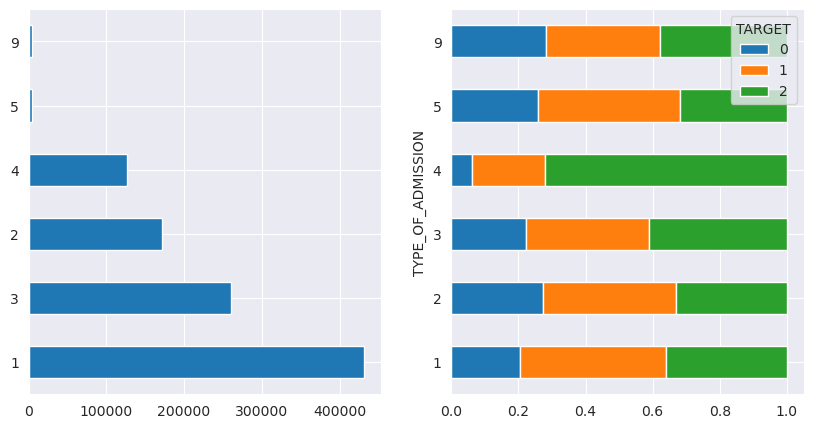

In [19]:
barh_cross_tab(df, "TYPE_OF_ADMISSION", "TARGET")

### Source of Admission 


In [20]:
df["SOURCE_OF_ADMISSION"].value_counts(dropna=False)

1      602529
2      174032
5      131212
4       65285
6        8782
8        7591
D        4861
9        4457
`         762
NaN       171
0          10
3           5
7           1
Name: SOURCE_OF_ADMISSION, dtype: int64

In [21]:
# change type to category
df["SOURCE_OF_ADMISSION"] = df["SOURCE_OF_ADMISSION"].astype("category")
assert df["SOURCE_OF_ADMISSION"].dtype.name == "category"

In [22]:
# mapping_SOA = {
#     "1": "NonHealthcare_Facility_POO",
#     "2": "Clinic Referal",
#     "4": "Transfer from Hospital",
#     "5": "Transfer from Nursing Facility",
#     "6": "Transfer from another Health Care Facility",
#     "8": "Court/Law Enforcement",
#     "9": "NA",
#     "`": "NA",
#     "D": "Internal Transfer"

# }



# ` is invalid make it 9 
df["SOURCE_OF_ADMISSION"] = df["SOURCE_OF_ADMISSION"].replace("`", "9")
#  NAN value 9
df["SOURCE_OF_ADMISSION"].fillna("9", inplace=True)
assert df["SOURCE_OF_ADMISSION"].isna().sum() == 0


In [23]:
df["SOURCE_OF_ADMISSION"].value_counts(dropna=False)

1    602529
2    174032
5    131212
4     65285
6      8782
8      7591
9      5390
D      4861
0        10
3         5
7         1
Name: SOURCE_OF_ADMISSION, dtype: int64

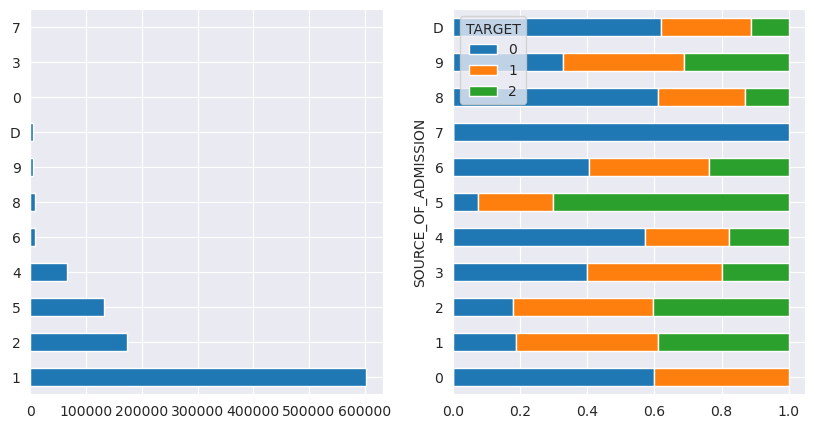

In [24]:
barh_cross_tab(df, "SOURCE_OF_ADMISSION", "TARGET")

### PAT_STATE
* Replace ` with U 
* NA are U 
* FC and XX both mean the same thing could merge them ???

In [25]:
df["PAT_STATE"].value_counts(dropna=False)

TX     971963
ZZ       8520
NM       5772
AR       4571
OK       3476
FC       2653
LA       2140
NaN       256
XX        239
`         108
Name: PAT_STATE, dtype: int64

In [26]:
df["PAT_STATE"].fillna("U", inplace=True)
df["PAT_STATE"].replace("`", "U", inplace=True)
assert df["PAT_STATE"].isna().sum() == 0

In [27]:
# change type to category
df["PAT_STATE"] = df["PAT_STATE"].astype("category")
assert df["PAT_STATE"].dtype.name == "category"


In [28]:
df["PAT_STATE"].value_counts(dropna=False)

TX    971963
ZZ      8520
NM      5772
AR      4571
OK      3476
FC      2653
LA      2140
U        364
XX       239
Name: PAT_STATE, dtype: int64

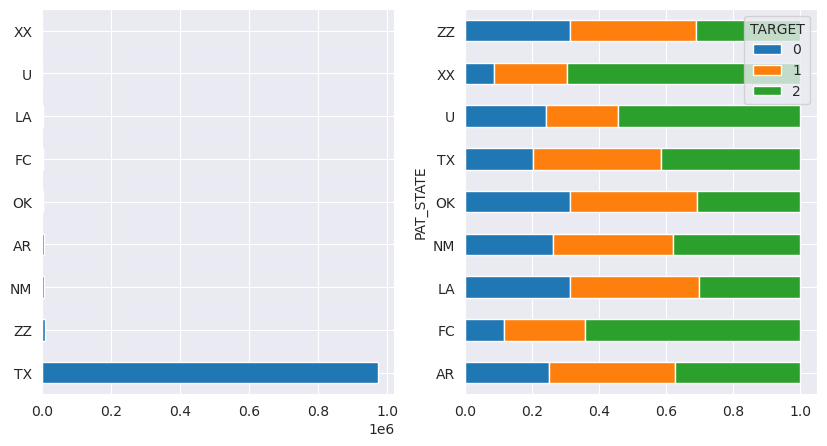

In [29]:
barh_cross_tab(df, "PAT_STATE", "TARGET")

### PAT_ZIP
* 1884 Value counts 
* We have state so we can drop zip
* lots of missing values 79k

#### DROP as we have already enough information about location this could add noise to the model

In [30]:
df["PAT_ZIP"].value_counts(dropna=False)

NaN      72042
88888     7745
78521     4044
`         3743
79936     3237
         ...  
324          1
182          1
021          1
601          1
076          1
Name: PAT_ZIP, Length: 1885, dtype: int64

### PAT_COUNTRY
* Other countries are not really significant we can do USA mexico and other and null

In [31]:
df["PAT_COUNTRY"].value_counts(dropna=False)

US     990594
NaN      6585
MX       2026
SA        117
QA         61
KW         52
AE         44
CA         42
PE         21
VE         20
IN         18
HN         18
`          17
CN         14
EC         13
GT         10
NG          9
SV          6
CO          6
DE          5
GB          4
NO          3
EG          3
TR          2
RU          2
PA          1
IT          1
KY          1
DK          1
CR          1
AR          1
Name: PAT_COUNTRY, dtype: int64

In [32]:
# only keep USA and MEXICO make NAN U and others Other
df["PAT_COUNTRY"].fillna("U", inplace=True)
df["PAT_COUNTRY"].replace("`", "U", inplace=True)
# not USA or MEXICO 
df["PAT_COUNTRY"] = df["PAT_COUNTRY"].apply(lambda x: "Other" if x not in ["US", "MX","U"] else x)
assert df["PAT_COUNTRY"].isna().sum() == 0


In [33]:
df["PAT_COUNTRY"].value_counts(dropna=False)

US       990594
U          6602
MX         2026
Other       476
Name: PAT_COUNTRY, dtype: int64

In [34]:
# change type to category
df["PAT_COUNTRY"] = df["PAT_COUNTRY"].astype("category")
assert df["PAT_COUNTRY"].dtype.name == "category"

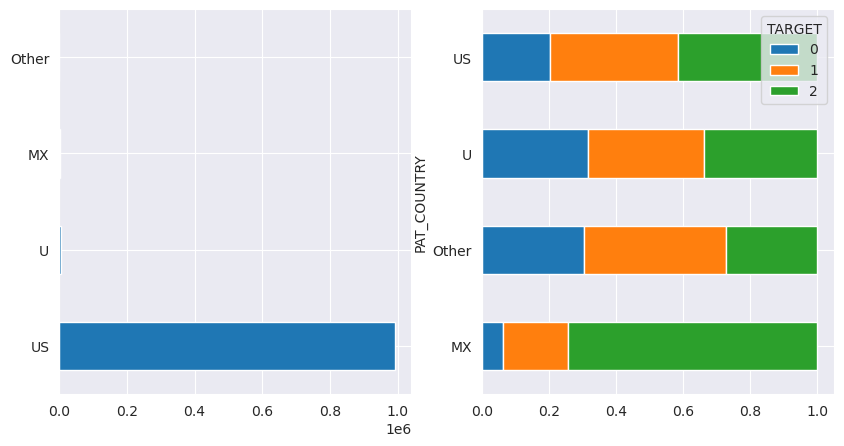

In [35]:
barh_cross_tab(df, "PAT_COUNTRY", "TARGET")

### COUNTY

In [36]:
df["COUNTY"].value_counts(dropna=False)

201    156638
113     93180
029     67060
439     65180
453     35182
        ...  
393        22
261        21
443        18
033        13
269         2
Name: COUNTY, Length: 254, dtype: int64

In [37]:
# change type to category
df["COUNTY"] = df["COUNTY"].astype("category")
assert df["COUNTY"].dtype.name == "category"

In [38]:
# hash encoder
he = HashingEncoder(n_components=7)
county_encoded = he.fit_transform(df["COUNTY"])
county_encoded = county_encoded.astype("category")

# rename columns in county_encoded and change to category type
county_encoded.columns = [f"COUNTY_{col}" for col in county_encoded.columns]

assert county_encoded.shape[0] == df.shape[0]

merged_dfs.append(county_encoded)

county_encoded.head()


,COUNTY_col_0,COUNTY_col_1,COUNTY_col_2,COUNTY_col_3,COUNTY_col_4,COUNTY_col_5,COUNTY_col_6
884115,0,1,0,0,0,0,0
33602,0,0,0,0,1,0,0
31627,0,0,1,0,0,0,0
112206,0,1,0,0,0,0,0
71288,0,0,1,0,0,0,0


### PUBLIC HEALTH REGION
* 11 values 
* make ` invalid be 0 as well as NAN

In [39]:
df["PUBLIC_HEALTH_REGION"].value_counts(dropna=False)

03     250838
06     231602
07     106116
08     100396
11      87188
04      46790
NaN     33483
05      33397
01      33004
10      31766
09      22981
02      22137
Name: PUBLIC_HEALTH_REGION, dtype: int64

In [40]:
df["PUBLIC_HEALTH_REGION"].isna().sum()

33483

In [41]:
# fill NAN with 00
df["PUBLIC_HEALTH_REGION"].fillna("00", inplace=True)
assert df["PUBLIC_HEALTH_REGION"].isna().sum() == 0

In [42]:
# change to category
df["PUBLIC_HEALTH_REGION"] = df["PUBLIC_HEALTH_REGION"].astype("category")
assert df["PUBLIC_HEALTH_REGION"].dtype.name == "category"


In [43]:
df["PUBLIC_HEALTH_REGION"].value_counts(dropna=False)

03    250838
06    231602
07    106116
08    100396
11     87188
04     46790
00     33483
05     33397
01     33004
10     31766
09     22981
02     22137
Name: PUBLIC_HEALTH_REGION, dtype: int64

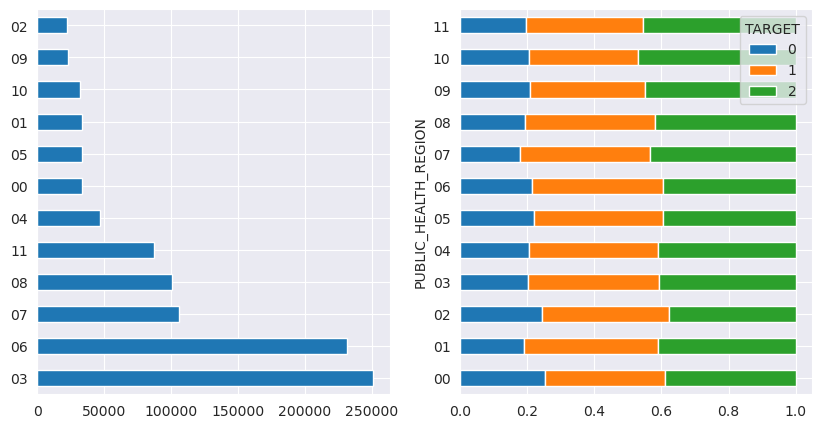

In [44]:
barh_cross_tab(df, "PUBLIC_HEALTH_REGION", "TARGET")

### SEX CODE

In [45]:
df["SEX_CODE"].value_counts(dropna=False)

F      561244
M      367642
NaN     70626
U         186
Name: SEX_CODE, dtype: int64

In [46]:
df["SEX_CODE"].fillna("U", inplace=True)
assert df["SEX_CODE"].isna().sum() == 0

In [47]:
df["SEX_CODE"].value_counts(dropna=False)

F    561244
M    367642
U     70812
Name: SEX_CODE, dtype: int64

In [48]:
#change to category
df["SEX_CODE"] = df["SEX_CODE"].astype("category")
assert df["SEX_CODE"].dtype.name == "category"


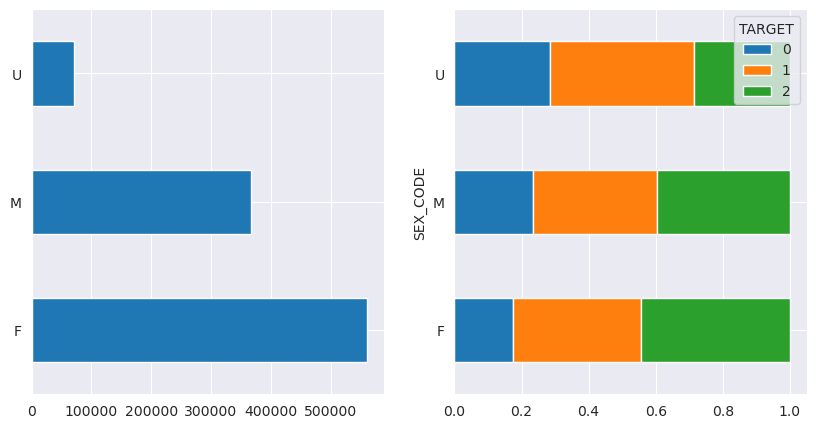

In [49]:
barh_cross_tab(df,"SEX_CODE", "TARGET")

### Race


In [50]:
df["RACE"].value_counts(dropna=False)

4      624277
5      216944
3      132390
2       19697
NaN      3644
1        2604
`         142
Name: RACE, dtype: int64

In [51]:
# nan, invalid are other meaning 5 

df["RACE"].fillna("5", inplace=True)
df["RACE"].replace("`", "5", inplace=True)

assert df["RACE"].isna().sum() == 0


In [52]:
# change to category
df["RACE"]= df["RACE"].astype("category")
assert df["RACE"].dtype.name == "category"


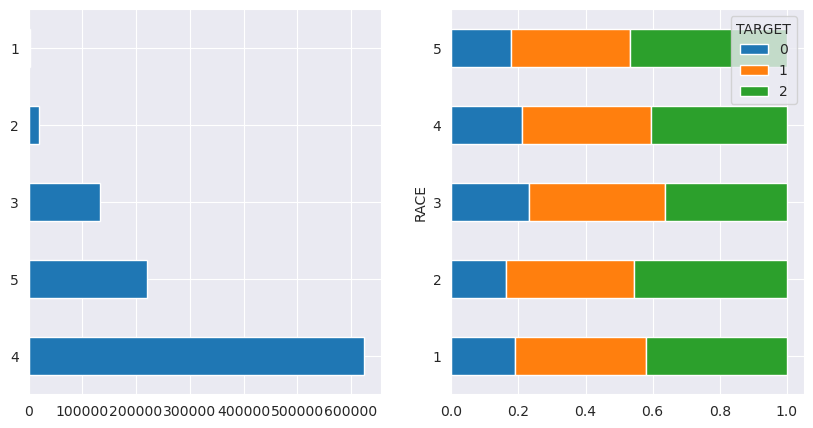

In [53]:
barh_cross_tab(df,"RACE", "TARGET")

### Ethnicity

In [54]:
df["ETHNICITY"].value_counts(dropna=False)

2      702507
1      286098
NaN      7110
`        3983
Name: ETHNICITY, dtype: int64

In [55]:
# nan, invalid are other meaning 0

df["ETHNICITY"].fillna("0", inplace=True)
df["ETHNICITY"].replace("`", "0", inplace=True)



In [56]:
df["ETHNICITY"].value_counts(dropna=False)

2    702507
1    286098
0     11093
Name: ETHNICITY, dtype: int64

In [57]:
# change to category
df["ETHNICITY"] = df["ETHNICITY"].astype("category")


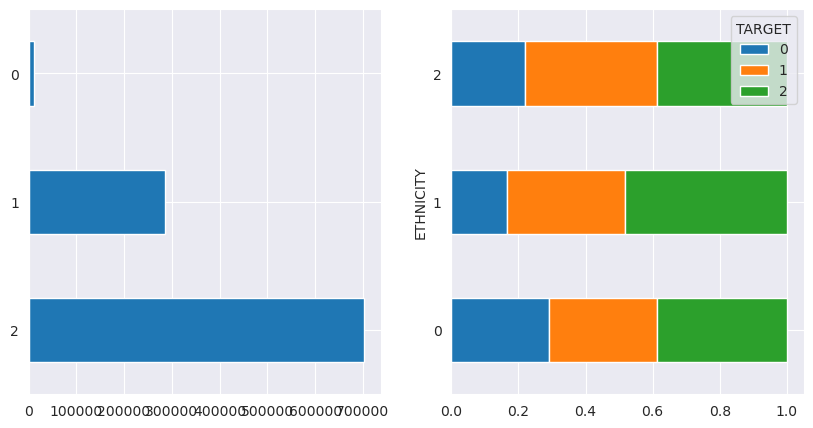

In [58]:
barh_cross_tab(df,"ETHNICITY", "TARGET")

### ADMIT WEEKDAY

In [59]:
df["ADMIT_WEEKDAY"].value_counts(dropna=False)

1    173199
2    170309
3    162260
4    155927
5    148880
6     96399
7     92724
Name: ADMIT_WEEKDAY, dtype: int64

In [60]:
# nan, invalid are other meaning 0
df["ADMIT_WEEKDAY"].fillna("0", inplace=True)
df["ADMIT_WEEKDAY"].replace("`", "0", inplace=True)
assert  df["ADMIT_WEEKDAY"].isna().sum() == 0


In [61]:
# change to category
df["ADMIT_WEEKDAY"] = df["ADMIT_WEEKDAY"].astype("category")
assert df["ADMIT_WEEKDAY"].dtype.name == "category"


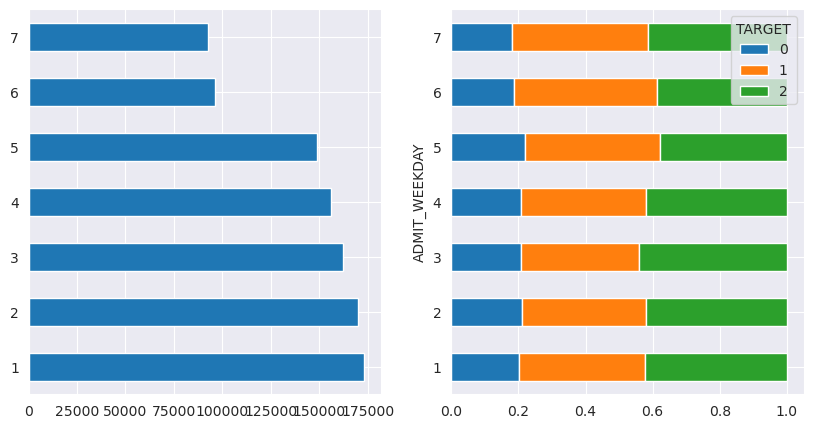

In [62]:
barh_cross_tab(df,"ADMIT_WEEKDAY", "TARGET")

### Admiting Diagnosis Code

In [63]:
df["ADMITTING_DIAGNOSIS"].value_counts(dropna=False)

V3000    78899
V221     49585
V3001    43332
78605    33668
78650    24446
         ...  
E8257        1
V1051        1
53511        1
1948         1
38423        1
Name: ADMITTING_DIAGNOSIS, Length: 6428, dtype: int64

In [64]:
# value counts greater than 1
df["ADMITTING_DIAGNOSIS"].value_counts()[df["ADMITTING_DIAGNOSIS"].value_counts() > 100]

V3000    78899
V221     49585
V3001    43332
78605    33668
78650    24446
         ...  
2929       101
4168       101
72886      101
3481       101
41001      101
Name: ADMITTING_DIAGNOSIS, Length: 766, dtype: int64

In [65]:
# hashing encoder   
he = HashingEncoder(n_components=7)
admitting_diagnosis_encoded = he.fit_transform(df["ADMITTING_DIAGNOSIS"])
admitting_diagnosis_encoded = admitting_diagnosis_encoded.astype("category")

# rename columns in admitting_diagnosis_encoded and change to category type
admitting_diagnosis_encoded.columns = [f"ADMITTING_DIAGNOSIS_{col}" for col in admitting_diagnosis_encoded.columns]

assert admitting_diagnosis_encoded.shape[0] == df.shape[0]

merged_dfs.append(admitting_diagnosis_encoded)

admitting_diagnosis_encoded.head()

,ADMITTING_DIAGNOSIS_col_0,ADMITTING_DIAGNOSIS_col_1,ADMITTING_DIAGNOSIS_col_2,ADMITTING_DIAGNOSIS_col_3,ADMITTING_DIAGNOSIS_col_4,ADMITTING_DIAGNOSIS_col_5,ADMITTING_DIAGNOSIS_col_6
884115,0,0,0,0,0,1,0
33602,0,0,0,0,0,0,1
31627,0,0,0,1,0,0,0
112206,1,0,0,0,0,0,0
71288,0,0,1,0,0,0,0


### PRINCE_DIAG_CODE and POA_PRINC_DIAG_CODE
* can only use the codes if the POA is Y

In [66]:

df["POA_PRINC_DIAG_CODE"].value_counts(dropna=False)


Y      750014
NaN    215428
N       26075
U        7378
W         492
`         311
Name: POA_PRINC_DIAG_CODE, dtype: int64

#### keep only the Y column values in POA Princ DIAg Code replase others with N


In [67]:
df.loc[df["POA_PRINC_DIAG_CODE"] != "Y", "PRINC_DIAG_CODE"] = "U"

In [68]:
df["PRINC_DIAG_CODE"].value_counts(dropna=False)

U        249684
0389      21830
486       18478
65421     18102
5849      11102
          ...  
64133         1
73606         1
20966         1
37487         1
2310          1
Name: PRINC_DIAG_CODE, Length: 6283, dtype: int64

In [69]:
df["PRINC_DIAG_CODE"].isna().sum
assert df["PRINC_DIAG_CODE"].isna().sum() == 0

* Missing a quater of the data

In [70]:
# encode PRINC_DIAG_CODE
he = HashingEncoder(n_components=7)
princ_diag_code_encoded = he.fit_transform(df["PRINC_DIAG_CODE"])
princ_diag_code_encoded = princ_diag_code_encoded.astype("category")

# rename columns in princ_diag_code_encoded and change to category type
princ_diag_code_encoded.columns = [f"PRINC_DIAG_CODE_{col}" for col in princ_diag_code_encoded.columns]

assert princ_diag_code_encoded.shape[0] == df.shape[0]

merged_dfs.append(princ_diag_code_encoded)

princ_diag_code_encoded.head()


,PRINC_DIAG_CODE_col_0,PRINC_DIAG_CODE_col_1,PRINC_DIAG_CODE_col_2,PRINC_DIAG_CODE_col_3,PRINC_DIAG_CODE_col_4,PRINC_DIAG_CODE_col_5,PRINC_DIAG_CODE_col_6
884115,0,1,0,0,0,0,0
33602,1,0,0,0,0,0,0
31627,0,0,0,1,0,0,0
112206,1,0,0,0,0,0,0
71288,0,0,1,0,0,0,0


### All other codes 
* If the patient had any previous diagnosis yes elseo no reduce the dimensions 
* number of other diagnosis codes

In [71]:

# list of POA CODES
# remove any column that does not start OTH_DIAG or POA_OTH or E_CODE or POA_E_CODE
df_poas = df.filter(regex="^(OTH_DIAG|POA_OTH|E_CODE|POA_E_CODE)").copy()

In [72]:
df_poas.shape

(999698, 68)

In [73]:
df_poas.head()

,OTH_DIAG_CODE_1,POA_OTH_DIAG_CODE_1,OTH_DIAG_CODE_2,POA_OTH_DIAG_CODE_2,OTH_DIAG_CODE_3,POA_OTH_DIAG_CODE_3,OTH_DIAG_CODE_4,POA_OTH_DIAG_CODE_4,OTH_DIAG_CODE_5,POA_OTH_DIAG_CODE_5,OTH_DIAG_CODE_6,POA_OTH_DIAG_CODE_6,OTH_DIAG_CODE_7,POA_OTH_DIAG_CODE_7,OTH_DIAG_CODE_8,POA_OTH_DIAG_CODE_8,OTH_DIAG_CODE_9,POA_OTH_DIAG_CODE_9,OTH_DIAG_CODE_10,POA_OTH_DIAG_CODE_10,OTH_DIAG_CODE_11,POA_OTH_DIAG_CODE_11,OTH_DIAG_CODE_12,POA_OTH_DIAG_CODE_12,OTH_DIAG_CODE_13,POA_OTH_DIAG_CODE_13,OTH_DIAG_CODE_14,POA_OTH_DIAG_CODE_14,OTH_DIAG_CODE_15,POA_OTH_DIAG_CODE_15,OTH_DIAG_CODE_16,POA_OTH_DIAG_CODE_16,OTH_DIAG_CODE_17,POA_OTH_DIAG_CODE_17,OTH_DIAG_CODE_18,POA_OTH_DIAG_CODE_18,OTH_DIAG_CODE_19,POA_OTH_DIAG_CODE_19,OTH_DIAG_CODE_20,POA_OTH_DIAG_CODE_20,OTH_DIAG_CODE_21,POA_OTH_DIAG_CODE_21,OTH_DIAG_CODE_22,POA_OTH_DIAG_CODE_22,OTH_DIAG_CODE_23,POA_OTH_DIAG_CODE_23,OTH_DIAG_CODE_24,POA_OTH_DIAG_CODE_24,E_CODE_1,POA_E_CODE_1,E_CODE_2,POA_E_CODE_2,E_CODE_3,POA_E_CODE_3,E_CODE_4,POA_E_CODE_4,E_CODE_5,POA_E_CODE_5,E_CODE_6,POA_E_CODE_6,E_CODE_7,POA_E_CODE_7,E_CODE_8,POA_E_CODE_8,E_CODE_9,POA_E_CODE_9,E_CODE_10,POA_E_CODE_10
884115,1919,Y,5119,Y,V8543,NaN,78459,Y,27801,Y,7812,Y,5180,Y,34590,Y,4019,Y,7993,Y,2724,Y,72887,Y,36250,Y,78093,Y,36901,Y,V5878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33602,42822,Y,4280,Y,496,Y,4139,Y,4019,Y,2720,Y,25000,Y,4148,Y,V4502,NaN,V4581,NaN,311,Y,30002,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31627,4019,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112206,5849,Y,25080,Y,2761,Y,42731,Y,2768,Y,42789,Y,4019,Y,2809,Y,5589,Y,2724,Y,42611,Y,49390,Y,V1588,NaN,7802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E9426,Y,E9413,Y,E9420,Y,E9443,Y,E9444,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### There is too manyt null values so we dont care about the codes just yes or no.

In [74]:
df_poas = df.filter(regex="^(POA_OTH|POA_E_CODE)").copy()

In [75]:
df_poas.head()

,POA_OTH_DIAG_CODE_1,POA_OTH_DIAG_CODE_2,POA_OTH_DIAG_CODE_3,POA_OTH_DIAG_CODE_4,POA_OTH_DIAG_CODE_5,POA_OTH_DIAG_CODE_6,POA_OTH_DIAG_CODE_7,POA_OTH_DIAG_CODE_8,POA_OTH_DIAG_CODE_9,POA_OTH_DIAG_CODE_10,POA_OTH_DIAG_CODE_11,POA_OTH_DIAG_CODE_12,POA_OTH_DIAG_CODE_13,POA_OTH_DIAG_CODE_14,POA_OTH_DIAG_CODE_15,POA_OTH_DIAG_CODE_16,POA_OTH_DIAG_CODE_17,POA_OTH_DIAG_CODE_18,POA_OTH_DIAG_CODE_19,POA_OTH_DIAG_CODE_20,POA_OTH_DIAG_CODE_21,POA_OTH_DIAG_CODE_22,POA_OTH_DIAG_CODE_23,POA_OTH_DIAG_CODE_24,POA_E_CODE_1,POA_E_CODE_2,POA_E_CODE_3,POA_E_CODE_4,POA_E_CODE_5,POA_E_CODE_6,POA_E_CODE_7,POA_E_CODE_8,POA_E_CODE_9,POA_E_CODE_10
884115,Y,Y,NaN,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33602,Y,Y,Y,Y,Y,Y,Y,Y,NaN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31627,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112206,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN
71288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# anything in poas that is not Y replace it with N
df_poas = df_poas.applymap(lambda x: "N" if x != "Y" else x)


In [77]:
print(df_poas["POA_OTH_DIAG_CODE_1"].isna().sum())
df_poas["POA_OTH_DIAG_CODE_1"].value_counts(dropna=False)

0


Y    668467
N    331231
Name: POA_OTH_DIAG_CODE_1, dtype: int64

In [78]:
# count the number of Y in each POA_OTH_DIAG row and add to new column smae for E_CODE
df_poas["POA_OTH_DIAG_CODE_COUNT"] = df_poas.filter(regex="^(POA_OTH_DIAG_CODE)").apply(lambda x: x.str.count("Y").sum(), axis=1)
df_poas["POA_E_CODE_COUNT"] = df_poas.filter(regex="^(POA_E_CODE)").apply(lambda x: x.str.count("Y").sum(), axis=1)

In [79]:
df_poas[["POA_OTH_DIAG_CODE_COUNT", "POA_E_CODE_COUNT"]].head()

,POA_OTH_DIAG_CODE_COUNT,POA_E_CODE_COUNT
884115,14,0
33602,10,0
31627,1,0
112206,12,5
71288,0,0


* These two counts will now be used in the model

In [80]:
# append to dataframe
df = pd.concat([df, df_poas[["POA_OTH_DIAG_CODE_COUNT", "POA_E_CODE_COUNT"]]], axis=1)

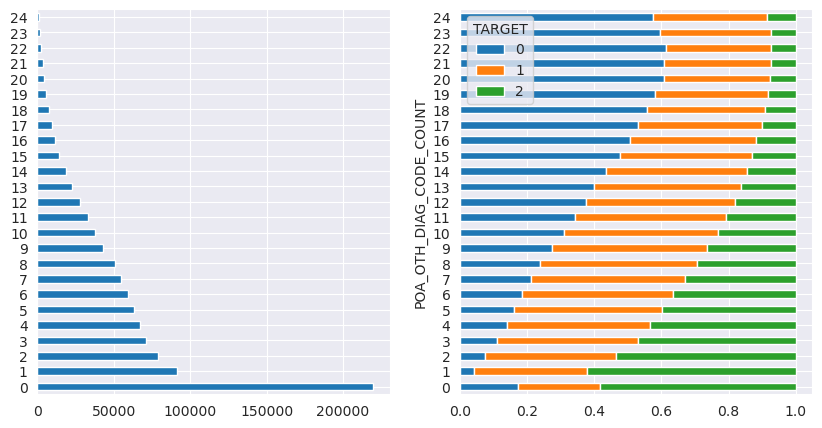

In [81]:
barh_cross_tab(df, "POA_OTH_DIAG_CODE_COUNT", "TARGET")

#### Very clean relation ship that the more diagnosis a person had the longer the stay
* not as clean for tha graph below, opposite could be said 7 diagnosis had all short stay.
* important to note that all NA and Unknown are added to 0. 

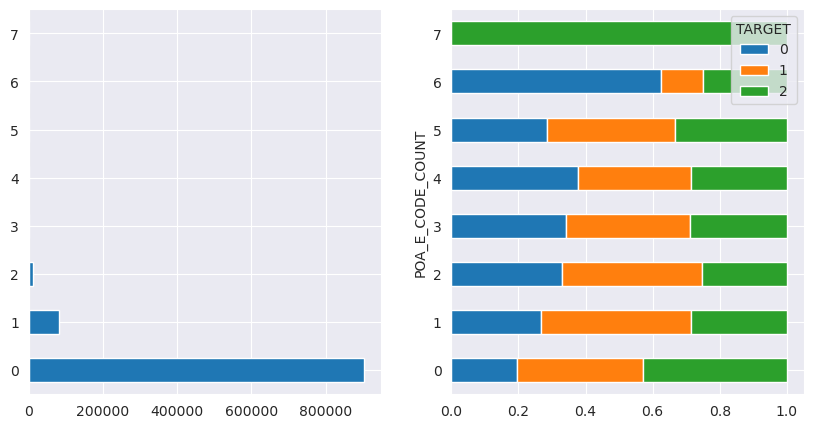

In [82]:
barh_cross_tab(df, "POA_E_CODE_COUNT", "TARGET")

#### Add all processed features into one dataframe.


In [83]:
#show only columns in known_on_admision
df[known_on_admission].head()
# +4 merged

,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_STATE,PAT_COUNTRY,PUBLIC_HEALTH_REGION,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,POA_PRINC_DIAG_CODE
884115,3,4,TX,US,06,F,4,2,2,V5789,U,NaN
33602,1,1,TX,US,03,M,5,1,2,78650,41401,Y
31627,1,1,TX,US,04,M,5,1,5,486,486,Y
112206,1,1,TX,US,06,F,4,2,1,7802,7802,Y
71288,1,1,TX,US,04,F,5,1,6,5409,5409,Y


In [84]:
# merge known  on admission

df_eda= pd.concat([df[known_on_admission], df["TARGET"]], axis=1)

# merge merged_dfs
df_eda = pd.concat([df_eda, *merged_dfs], axis=1)

# merge poa code count
df_eda = pd.concat([df_eda, df_poas[["POA_OTH_DIAG_CODE_COUNT", "POA_E_CODE_COUNT"]]], axis=1)


In [85]:
df_eda.describe()

,POA_OTH_DIAG_CODE_COUNT,POA_E_CODE_COUNT
count,999698.000000,999698.000000
mean,5.273096,0.112725
std,5.063864,0.372757
min,0.000000,0.000000
25%,1.000000,0.000000
50%,4.000000,0.000000
75%,8.000000,0.000000
max,24.000000,7.000000


In [86]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999698 entries, 884115 to 121996
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   TYPE_OF_ADMISSION          999698 non-null  category
 1   SOURCE_OF_ADMISSION        999698 non-null  category
 2   PAT_STATE                  999698 non-null  category
 3   PAT_COUNTRY                999698 non-null  category
 4   PUBLIC_HEALTH_REGION       999698 non-null  category
 5   SEX_CODE                   999698 non-null  category
 6   RACE                       999698 non-null  category
 7   ETHNICITY                  999698 non-null  category
 8   ADMIT_WEEKDAY              999698 non-null  category
 9   ADMITTING_DIAGNOSIS        998506 non-null  object  
 10  PRINC_DIAG_CODE            999698 non-null  object  
 11  POA_PRINC_DIAG_CODE        784270 non-null  object  
 12  TARGET                     999698 non-null  category
 13  PROVIDER_

## Summary
* 

In [87]:
print("Randomising order ...")
df_sample = df_eda.sample(frac=1, random_state=SEED)

for parts in [10,5,2,1]:
    nrows = df_eda.shape[0] // parts
    print(f"\nBreak dataset into {parts} each with {nrows} rows ... ", end="")

    for k in range(parts):
        filename = f"{ROOT}/data/df_train_preprocess_%02d_of_%d.pkl" % (k, parts)

        print(k, end=" ")
        df_sample.iloc[k * nrows : (k + 1) * nrows].to_pickle(filename)

Randomising order ...

Break dataset into 10 each with 99969 rows ... 0 1 2 3 4 5 6 7 8 9 
Break dataset into 5 each with 199939 rows ... 0 1 2 3 4 
Break dataset into 2 each with 499849 rows ... 0 1 
Break dataset into 1 each with 999698 rows ... 0 

 # Ordinal encodec can be used in a pipeline